In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [10]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False, transform=transform)

Files already downloaded and verified


In [12]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

In [13]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [14]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cpu')

In [15]:
def get_gaussian_image(batch, w, h):
    # CIFAR 10 mean and std in RGB format. Source: https://github.com/facebookarchive/fb.resnet.torch/issues/180
    mean = [125.3, 123.0, 113.9]
    std = [63.0, 62.1, 66.7]
    out = list()
    for i in range(batch):
        r_channel = torch.normal(mean[0], std[0], size=(w, h)).unsqueeze(0)
        g_channel = torch.normal(mean[1], std[1], size=(w, h)).unsqueeze(0)
        b_channel = torch.normal(mean[2], std[2], size=(w, h)).unsqueeze(0)
        out.append(torch.cat((r_channel, g_channel, b_channel), dim=0).unsqueeze(0))
    return torch.cat(out, dim=0)

def eval_model(model,trainloader,testloader):
  model.eval()
  correct = 0
  total = 0
  for i, data in enumerate(testloader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  acc_v = (correct / total)

  correct = 0
  total = 0            
  for i, data in enumerate(trainloader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  acc_t = (correct / total)
  return acc_t,acc_v

def fit(epoch, model, trainloader, testloader, optimizer,scheduler,name='model', random_shuffle=False, shuffled_pixels=False, random_pixels=False, gaussian_noise=False):
  history_t = []
  history_v = []
  history_loss = []
  step_count = 0
  criterion = nn.CrossEntropyLoss().to(device)
  if random_pixels:
    rng = np.random.default_rng()
  for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      if random_shuffle:
        # The permutation should be the same for every epoch
        torch.manual_seed(0)
        labels = labels[torch.randperm(len(labels))]
      if shuffled_pixels:
        data_ = inputs.cpu().numpy()
        # Resetting the random generator every time to generate the same set of permutation
        rng = np.random.default_rng(26)
        data_perm = rng.permutation(data_, axis=2)
        data = torch.from_numpy(data_perm)
      if random_pixels:
        data_ = inputs.cpu().numpy()
        # Generating a different set of permutation every time
        data_perm = rng.permutation(data_, axis=2)
        data = torch.from_numpy(data_perm)
      if gaussian_noise:
        batch = inputs.shape[0]
        w = inputs.shape[-1]
        h = inputs.shape[-2]
        data = get_gaussian_image(batch, w, h)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      step_count += 1
      if step_count%1000==0:
        acc_t,acc_v = eval_model(model,trainloader,testloader)
        model.train()
        history_t.append(acc_t)
        history_v.append(acc_v)
        log_ = str(step_count)+","+str(acc_t)+","+str(acc_v)+ "," + str(running_loss/1000)+"\n"
        with open("{}.log".format(name), "a") as f:
          f.write(log_)
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss/1000,acc_t, acc_v))
    history_loss.append(running_loss/1000)
    scheduler.step()
  return model,history_t,history_v, history_loss

In [ ]:
final_dict = dict()

# Shuffled Pixels

In [ ]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss_shuffled_pixels = fit(100, net, trainloader, testloader, optimizer,scheduler, name='shuffled_pixels', shuffled_pixels=True)

Epoch 1 | loss: 3.9697 | Train acc: 0.1001 | Val acc: 0.1001
Epoch 2 | loss: 3.6089 | Train acc: 0.1000 | Val acc: 0.1001
Epoch 3 | loss: 3.6095 | Train acc: 0.1000 | Val acc: 0.0998
Epoch 4 | loss: 3.6072 | Train acc: 0.1001 | Val acc: 0.1001
Epoch 5 | loss: 3.3799 | Train acc: 0.1808 | Val acc: 0.1814
Epoch 6 | loss: 2.9482 | Train acc: 0.3498 | Val acc: 0.3490
Epoch 7 | loss: 2.6498 | Train acc: 0.3937 | Val acc: 0.3923
Epoch 8 | loss: 2.4685 | Train acc: 0.4330 | Val acc: 0.4335
Epoch 9 | loss: 2.3330 | Train acc: 0.4811 | Val acc: 0.4714
Epoch 10 | loss: 2.2021 | Train acc: 0.5125 | Val acc: 0.4985
Epoch 11 | loss: 2.0730 | Train acc: 0.5291 | Val acc: 0.5140
Epoch 12 | loss: 1.9530 | Train acc: 0.5699 | Val acc: 0.5546
Epoch 13 | loss: 1.8414 | Train acc: 0.6086 | Val acc: 0.5822
Epoch 14 | loss: 1.7400 | Train acc: 0.6170 | Val acc: 0.5945
Epoch 15 | loss: 1.6440 | Train acc: 0.6610 | Val acc: 0.6171
Epoch 16 | loss: 1.5598 | Train acc: 0.6783 | Val acc: 0.6372
Epoch 17 | loss: 

In [ ]:
plt.plot(list(history_loss_shuffled_pixels), label='shuffled pixels')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()

In [ ]:
final_dict['shuffled_pixels']={}
final_dict['shuffled_pixels']['train_losses'] = history_loss_shuffled_pixels

In [ ]:
with open('final_input1.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# Random pixels

In [9]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss_random_pixels = fit(100, net, trainloader, testloader, optimizer,scheduler, name='random_pixels', random_pixels=True)

Epoch 1 | loss: 3.9594 | Train acc: 0.1000 | Val acc: 0.0999
Epoch 2 | loss: 3.6094 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 3 | loss: 3.6084 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 4 | loss: 3.6087 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 5 | loss: 3.6082 | Train acc: 0.1000 | Val acc: 0.1002
Epoch 6 | loss: 3.6079 | Train acc: 0.1000 | Val acc: 0.0999
Epoch 7 | loss: 3.6077 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 8 | loss: 3.6069 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 9 | loss: 3.6058 | Train acc: 0.1001 | Val acc: 0.1001
Epoch 10 | loss: 3.5901 | Train acc: 0.1000 | Val acc: 0.1001
Epoch 11 | loss: 3.1132 | Train acc: 0.3111 | Val acc: 0.3141
Epoch 12 | loss: 2.7364 | Train acc: 0.3744 | Val acc: 0.3675
Epoch 13 | loss: 2.5432 | Train acc: 0.4135 | Val acc: 0.4054
Epoch 14 | loss: 2.4163 | Train acc: 0.4276 | Val acc: 0.4229
Epoch 15 | loss: 2.3056 | Train acc: 0.4642 | Val acc: 0.4559
Epoch 16 | loss: 2.2001 | Train acc: 0.5125 | Val acc: 0.4954
Epoch 17 | loss: 

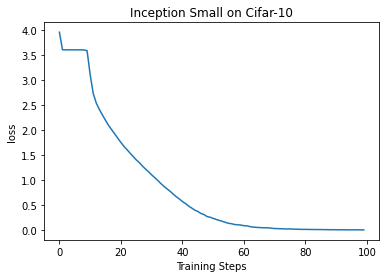

In [10]:
plt.plot(list(history_loss_random_pixels), label='random pixels')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()

In [ ]:
final_dict['random_pixels']={}
final_dict['random_pixels']['train_losses'] = history_loss_random_pixels

In [ ]:
with open('final_input2.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# Gaussian Noise

In [13]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1, history_loss_gaussian_noise = fit(100, net, trainloader, testloader, optimizer,scheduler, name='gaussian_noise', gaussian_noise=True)

Epoch 1 | loss: 4.0553 | Train acc: 0.1110 | Val acc: 0.1111
Epoch 2 | loss: 3.6099 | Train acc: 0.1006 | Val acc: 0.1005
Epoch 3 | loss: 3.6095 | Train acc: 0.1001 | Val acc: 0.0999
Epoch 4 | loss: 3.6069 | Train acc: 0.1015 | Val acc: 0.1013
Epoch 5 | loss: 3.3042 | Train acc: 0.2467 | Val acc: 0.2529
Epoch 6 | loss: 2.8133 | Train acc: 0.3564 | Val acc: 0.3637
Epoch 7 | loss: 2.5073 | Train acc: 0.4051 | Val acc: 0.4014
Epoch 8 | loss: 2.2503 | Train acc: 0.5094 | Val acc: 0.5061
Epoch 9 | loss: 2.0219 | Train acc: 0.5727 | Val acc: 0.5628
Epoch 10 | loss: 1.8275 | Train acc: 0.5924 | Val acc: 0.5815
Epoch 11 | loss: 1.6889 | Train acc: 0.6456 | Val acc: 0.6255
Epoch 12 | loss: 1.5666 | Train acc: 0.6719 | Val acc: 0.6481
Epoch 13 | loss: 1.4521 | Train acc: 0.6947 | Val acc: 0.6666
Epoch 14 | loss: 1.3534 | Train acc: 0.7029 | Val acc: 0.6693
Epoch 15 | loss: 1.4683 | Train acc: 0.6969 | Val acc: 0.6669
Epoch 16 | loss: 1.2561 | Train acc: 0.7566 | Val acc: 0.7053
Epoch 17 | loss: 

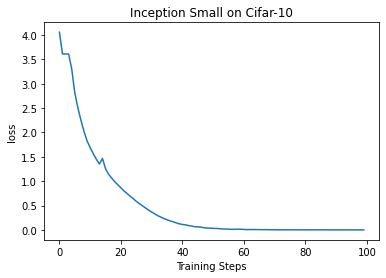

In [14]:
plt.plot(list(history_loss_gaussian_noise), label='Gaussian Noise')
plt.xlabel('Training Steps')
plt.ylabel('loss')
plt.title('Inception Small on Cifar-10')
plt.show()

In [ ]:
final_dict['gaussian_noise']={}
final_dict['gaussian_noise']['train_losses'] = history_loss_gaussian_noise

In [ ]:
with open('final_input3.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)